# Pipeline labelisation

## Imports des packages

In [1]:
import sys
sys.path.append('../src')
import shutil
import yaml
import py7zr
import os
import s3fs
from satellite_image import SatelliteImage
from labeler import RILLabeler
from labeler import BDTOPOLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot as rp
import re
from datetime import datetime
from tqdm import tqdm

## Téléchargement des données Pléiades

In [2]:
with open("../environment.yml") as f:
    environment = yaml.safe_load(f)

bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["cayenne"]
path_s3_bdtopo_data = environment["sources"]["bdtopo"][2022]["guyane"]
path_local_cayenne_data = environment["local-path"]["cayenne"]
path_local_bdtopo_data = environment["local-path"]["bdtopo"][2022]["guyane"]

#fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},key ='D5IOLRUBWV7ESESXMI6I', secret = 'J1v7EdczwFYHjr8rF4BMisCub3vVpZVHz0vnWVMG', token = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJENUlPTFJVQldWN0VTRVNYTUk2SSIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjc1NzkwMDczLCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6InRob21hcy5mYXJpYUBpbnNlZS5mciIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJleHAiOjE2NzU4NzgzNjMsImZhbWlseV9uYW1lIjoiRmFyaWEiLCJnaXZlbl9uYW1lIjoiVGhvbWFzIiwiZ3JvdXBzIjpbImFwZSIsImVzYS1ub3djYXN0aW5nIiwiZm9ybWF0aW9uIiwiaGFja2F0aG9uLW50dHMtMjAyMyIsInNlbG9nZXIiLCJzbHVtcy1kZXRlY3Rpb24iXSwiaWF0IjoxNjc1NzkxOTYxLCJpc3MiOiJodHRwczovL2F1dGgubGFiLnNzcGNsb3VkLmZyL2F1dGgvcmVhbG1zL3NzcGNsb3VkIiwianRpIjoiMDI2ZTI2YTktMTYwMS00MDgwLTliODQtMDkxN2Y4N2UyMTE5IiwibmFtZSI6IlRob21hcyBGYXJpYSIsIm5vbmNlIjoiMWUyMWMxNzAtZWY0ZC00MWI2LTkwMjgtNjVlNDI0Yjc0ODhhIiwicG9saWN5Ijoic3Rzb25seSIsInByZWZlcnJlZF91c2VybmFtZSI6InRmYXJpYSIsInJlYWxtX2FjY2VzcyI6eyJyb2xlcyI6WyJvZmZsaW5lX2FjY2VzcyIsInVtYV9hdXRob3JpemF0aW9uIiwiZGVmYXVsdC1yb2xlcy1zc3BjbG91ZCJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIHByb2ZpbGUgZ3JvdXBzIGVtYWlsIiwic2Vzc2lvblBvbGljeSI6ImV5SldaWEp6YVc5dUlqb2lNakF4TWkweE1DMHhOeUlzSWxOMFlYUmxiV1Z1ZENJNlczc2lSV1ptWldOMElqb2lRV3hzYjNjaUxDSkJZM1JwYjI0aU9sc2ljek02S2lKZExDSlNaWE52ZFhKalpTSTZXeUpoY200NllYZHpPbk16T2pvNmNISnZhbVYwTFhOc2RXMXpMV1JsZEdWamRHbHZiaUlzSW1GeWJqcGhkM002Y3pNNk9qcHdjbTlxWlhRdGMyeDFiWE10WkdWMFpXTjBhVzl1THlvaVhYMHNleUpGWm1abFkzUWlPaUpCYkd4dmR5SXNJa0ZqZEdsdmJpSTZXeUp6TXpwTWFYTjBRblZqYTJWMElsMHNJbEpsYzI5MWNtTmxJanBiSW1GeWJqcGhkM002Y3pNNk9qb3FJbDBzSWtOdmJtUnBkR2x2YmlJNmV5SlRkSEpwYm1kTWFXdGxJanA3SW5Nek9uQnlaV1pwZUNJNkltUnBabVoxYzJsdmJpOHFJbjE5ZlN4N0lrVm1abVZqZENJNklrRnNiRzkzSWl3aVFXTjBhVzl1SWpwYkluTXpPa2RsZEU5aWFtVmpkQ0pkTENKU1pYTnZkWEpqWlNJNld5SmhjbTQ2WVhkek9uTXpPam82S2k5a2FXWm1kWE5wYjI0dktpSmRmVjE5Iiwic2Vzc2lvbl9zdGF0ZSI6IjdjYzMyODAyLWMxMjAtNGY3Ni1hNzg4LWY2NzY0Y2Q5MDQxYiIsInNpZCI6IjdjYzMyODAyLWMxMjAtNGY3Ni1hNzg4LWY2NzY0Y2Q5MDQxYiIsInN1YiI6IjlkZTdmMjkxLWY2NTctNDZlMi05ZjQ1LWFjZjdhNDU3Y2YyZSIsInR5cCI6IkJlYXJlciJ9.db7LoNMVpUCT_RBKYj8r1n2Fm5_5JvnbNcX2rRn0Mig87bkbXhqWt8FShr6RD0x0Pgy68YaAinY4GowyS3529A')

On extrait les données des zips

In [3]:
fs.get(f"{bucket}/{path_s3_cayenne_data}", f"../{path_local_cayenne_data}")
with py7zr.SevenZipFile(f"../{path_local_cayenne_data}", mode="r") as z:
    z.extractall()

fs.get(f"{bucket}/{path_s3_bdtopo_data}", f"../{path_local_bdtopo_data}")
with py7zr.SevenZipFile(f"../{path_local_bdtopo_data}", mode="r") as z:
    z.extractall()

On les déplace dans le dossiers data

In [4]:
shutil.move(
    os.path.splitext(os.path.basename(path_s3_bdtopo_data))[0],
    os.path.splitext(f"../{path_local_bdtopo_data}")[0],
)
    
shutil.move(
    os.path.splitext(os.path.basename(path_s3_cayenne_data))[0],
    os.path.splitext(f"../{path_local_cayenne_data}")[0],
)

'../data/Cayenne'

## Découpage et filtrage des images

In [5]:
images_paths = ["../data/Cayenne/16bits/ORT_2022072050325085_U22N/" + p for p in os.listdir(f"../data/Cayenne/16bits/ORT_2022072050325085_U22N/")]

In [6]:
date = datetime.strptime(re.search(r'ORT_(\d{8})', images_paths[0]).group(1), '%Y%m%d')

On importes les `SatelliteImage` dans une liste.

In [7]:
list_images = [
     SatelliteImage.from_raster(
        filename,
        date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d'), 
        n_bands = 4
    ) for filename in tqdm(images_paths)]

100%|██████████| 240/240 [00:43<00:00,  5.50it/s]


On découpe les images initialement de dimension 2000 en plusieurs image de dimension `dim`. On ne garde ensuite que les images qui sont pertinentes à l'aide de la méthode `filter_images`. Une image contenant moins de 50% de pixels non noirs n'est pas retenue.

In [8]:
dim = 250

In [9]:
splitted_list_images = [SatelliteImage.filter_images(im) for sublist in tqdm(list_images) for im in sublist.split(250) if SatelliteImage.filter_images(im) is not None]

100%|██████████| 240/240 [00:12<00:00, 19.30it/s]


In [10]:
len(splitted_list_images)

13254

On peut représenter graphiquement nos images grâce à la méthode `plot` :

In [ ]:
splitted_list_images[0].plot([0, 1, 2]) # RGB (3 premières bandes)

On peut représenter l'image infrarouge : 

In [ ]:
splitted_list_images[0].plot([3, 0, 1]) # RGB (Infrarouge, rouge, vert)

Ou bien qu'une seule bande :

In [ ]:
splitted_list_images[0].plot([0]) # Une bande

## Labélisation avec le RIL

In [14]:
%env AWS_ACCESS_KEY_ID=projet-slums-sa
%env AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr

env: AWS_ACCESS_KEY_ID=projet-slums-sa
env: AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr


On définit un `labeler` incluant la taille des buffers que l'on souhaite ainsi que la forme de ceux-ci.

In [ ]:
labeler_RIL = RILLabeler(date, buffer_size=6, cap_style=3)

A l'aide de notre `labeler` on créer une `SegmentationLabeledSatelliteImage`.

In [16]:
list_labeled_images = [
     SegmentationLabeledSatelliteImage(
        sat_im,
        labeler_RIL.create_segmentation_label(sat_im),
        "RIL",
        date
     ) for sat_im in tqdm(splitted_list_images)]

100%|██████████| 13254/13254 [02:34<00:00, 85.79it/s] 


Il est également possible de représenter graphiquement l'image ainsi que son label grâce à la méthode `plot()`. Ici un exemple d'image ou l'on constate la présence d'immeubles : 

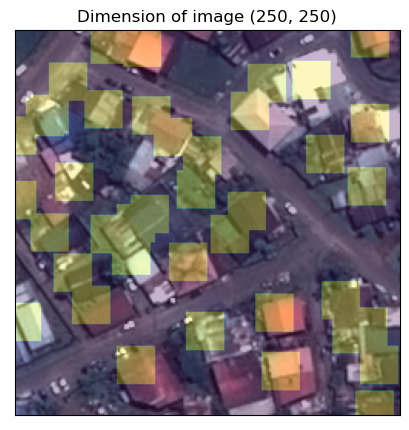

In [17]:
list_labeled_images[189].plot([0,1,2])

Et voici un exemple sans immeuble : 

In [ ]:
list_labeled_images[0].plot([0,1,2])

## Labélisation avec la BDTOPO

On peut réaliser la labelisation grâce à la BDTOPO plutôt que le RIL afin d'avoir des contours plus précis.

In [ ]:
labeler_BDTOPO = BDTOPOLabeler(date)

In [ ]:
list_labeled_images = [
     SegmentationLabeledSatelliteImage(
        sat_im,
        labeler_BDTOPO.create_segmentation_label(sat_im),
        "BDTOPO",
        date
     ) for sat_im in tqdm(splitted_list_images)]

In [ ]:
list_labeled_images[189].plot([0,1,2])

In [ ]:
list_labeled_images[0].plot([0,1,2])